In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects  as PathEffects
from matplotlib.patches import Patch
import seaborn as sns
sns.set(style="white")
import torch
from sklearn.decomposition import PCA

from emocoder.src import utils, constants
from emocoder.experiments import utils as xutils, constants as xconstants


from emocoder.experiments.word.multitask import Fit_Word_Encoders_on_Multiple_Datasets as experiment
from emocoder.src.data.words import ANEW1999,Stadthagen_VA, Vo, Riegel, Kapucu_VA
from emocoder.src import data

from emocoder.src.experiments import get_best_checkpoint
from emocoder.src.utils import get_experiment_dir


In [3]:
acl_columnwidth_in_inch = 7.7 / 2.54

## Define `pca2d` and Plot Decoder Positions

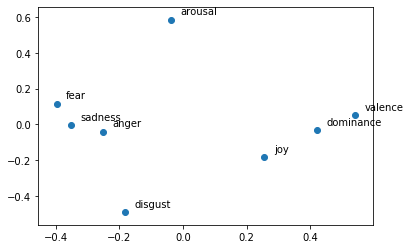

In [3]:
model, state_dict = xutils.get_pretrained_emotion_codec()

vectors = {}

vectors["val"] = state_dict.get("dec.pool.vad.weight")[0]
vectors["aro"] = state_dict.get("dec.pool.vad.weight")[1]
vectors["dom"] = state_dict.get("dec.pool.vad.weight")[2]

vectors["joy"] = state_dict.get("dec.pool.be5.weight")[0]
vectors["ang"]  =state_dict.get("dec.pool.be5.weight")[1]
vectors["sad"] =state_dict.get("dec.pool.be5.weight")[2]
vectors["fea"] =state_dict.get("dec.pool.be5.weight")[3]
vectors["dis"] =state_dict.get("dec.pool.be5.weight")[4]

vectors = {key: val.numpy() for key,val in vectors.items()}
variables = pd.DataFrame.from_dict(vectors, orient="index")

pca2d = PCA(n_components=2)
varNames = {"val": "valence",
            "aro": "arousal",
            "dom": "dominance",
            "joy": "joy",
            "ang": "anger",
            "fea": "fear",
            "sad": "sadness",
            "dis": "disgust"}
rt = pca2d.fit_transform(variables)
fig, ax = plt.subplots()
ax.scatter(rt[:,0], rt[:,1])
for i in range(len(rt)):
    ax.text(x=rt[i,0]+.03, y=rt[i,1]+.03, s=varNames[variables.index[i]])

In [4]:
EN = get_best_checkpoint(get_experiment_dir(xconstants.WORD_MULTITASK_BASEPATH/ "dev", "Fit-Word-Encoder-on-English-2020-09-18-135857"))
ES = get_best_checkpoint(get_experiment_dir(xconstants.WORD_MULTITASK_BASEPATH / "dev", "Fit-Word-Encoder-on-Spanish-2020-09-18-140139"))
DE = get_best_checkpoint(get_experiment_dir(xconstants.WORD_MULTITASK_BASEPATH / "dev", "Fit-Word-Encoder-on-German-2020-09-18-141621"))
PL = get_best_checkpoint(get_experiment_dir(xconstants.WORD_MULTITASK_BASEPATH / "dev", "Fit-Word-Encoder-on-Polish-2020-09-18-142015"))
TR = get_best_checkpoint(get_experiment_dir(xconstants.WORD_MULTITASK_BASEPATH / "dev", "Fit-Word-Encoder-on-Turkish-2020-09-18-142618"))



checkpoint_en = torch.load(EN)
checkpoint_es = torch.load(ES)
checkpoint_de = torch.load(DE)
checkpoint_pl = torch.load(PL)
checkpoint_tr = torch.load(TR)

model_en, __ = experiment.get_model()
model_es, __ = experiment.get_model()
model_de, __ = experiment.get_model()
model_pl, __ = experiment.get_model()
model_tr, __ = experiment.get_model()

model_en.load_state_dict(checkpoint_en, strict=False)
model_es.load_state_dict(checkpoint_es, strict=False)
model_de.load_state_dict(checkpoint_de, strict=False)
model_pl.load_state_dict(checkpoint_pl, strict=False)
model_tr.load_state_dict(checkpoint_tr, strict=False)

transform_en  = data.Embedding_Lookup_Transform(embeddings="FB_CC_EN", limit=None)
transform_es = data.Embedding_Lookup_Transform(embeddings="FB_CC_ES", limit=None)
transform_de = data.Embedding_Lookup_Transform(embeddings="FB_CC_DE", limit=None)
transform_pl = data.Embedding_Lookup_Transform(embeddings="FB_CC_PL", limit=None)
transform_tr = data.Embedding_Lookup_Transform(embeddings="FB_CC_TR", limit=None)

ds_en = ANEW1999(split="full", transform=transform_en)
ds_es = Stadthagen_VA(split="full", transform=transform_es)
ds_de = Vo(split="full", transform=transform_de)
ds_pl = Riegel(split="full", transform=transform_pl)
ds_tr = Kapucu_VA(split="full", transform=transform_tr)

# hacky repair of turkish dataset
ds_tr.df.rename(inplace=True, index={"teröri̇st":"terörist", "i̇yi̇leşmek": "iyileşmek"})

def get_emotion_embeddings(model, dataset, device=torch.device("cuda:0")):
    emb_list = []
    word_list = []
    dl = torch.utils.data.DataLoader(dataset=dataset, shuffle=False, batch_size=128)
    model.to(device=device)
    model.eval()
    with torch.no_grad():
        for batch in dl:
            words = batch["raw"]
            features = batch["features"].to(device)
            embs = model.enc(x=features, encoder="words")
            word_list += words
            emb_list.append(embs)
    embs = torch.cat(emb_list).cpu().numpy()
    return word_list, embs

words_en, embs_en = get_emotion_embeddings(model_en, ds_en)
words_es, embs_es = get_emotion_embeddings(model_es, ds_es)
words_de, embs_de = get_emotion_embeddings(model_de, ds_de)
words_pl, embs_pl = get_emotion_embeddings(model_pl, ds_pl)
words_tr, embs_tr = get_emotion_embeddings(model_tr, ds_tr)


df_en = pd.DataFrame(index=words_en, data=embs_en)
df_es = pd.DataFrame(index=words_es, data=embs_es)
df_de = pd.DataFrame(index=words_de, data=embs_de)
df_pl = pd.DataFrame(index=words_pl, data=embs_pl)
df_tr = pd.DataFrame(index=words_tr, data=embs_tr)

en2d = pd.DataFrame(index=df_en.index, data=pca2d.transform(df_en.values))
es2d = pd.DataFrame(index=df_es.index, data=pca2d.transform(df_es.values))
de2d = pd.DataFrame(index=df_de.index, data=pca2d.transform(df_de.values))
pl2d = pd.DataFrame(index=df_pl.index, data=pca2d.transform(df_pl.values))
tr2d = pd.DataFrame(index=df_tr.index, data=pca2d.transform(df_tr.values))

vars2d = pd.DataFrame(index=variables.index, data=pca2d.transform(variables))

## Plot Top/Bottom Words for V, A, and disgust for All Languages

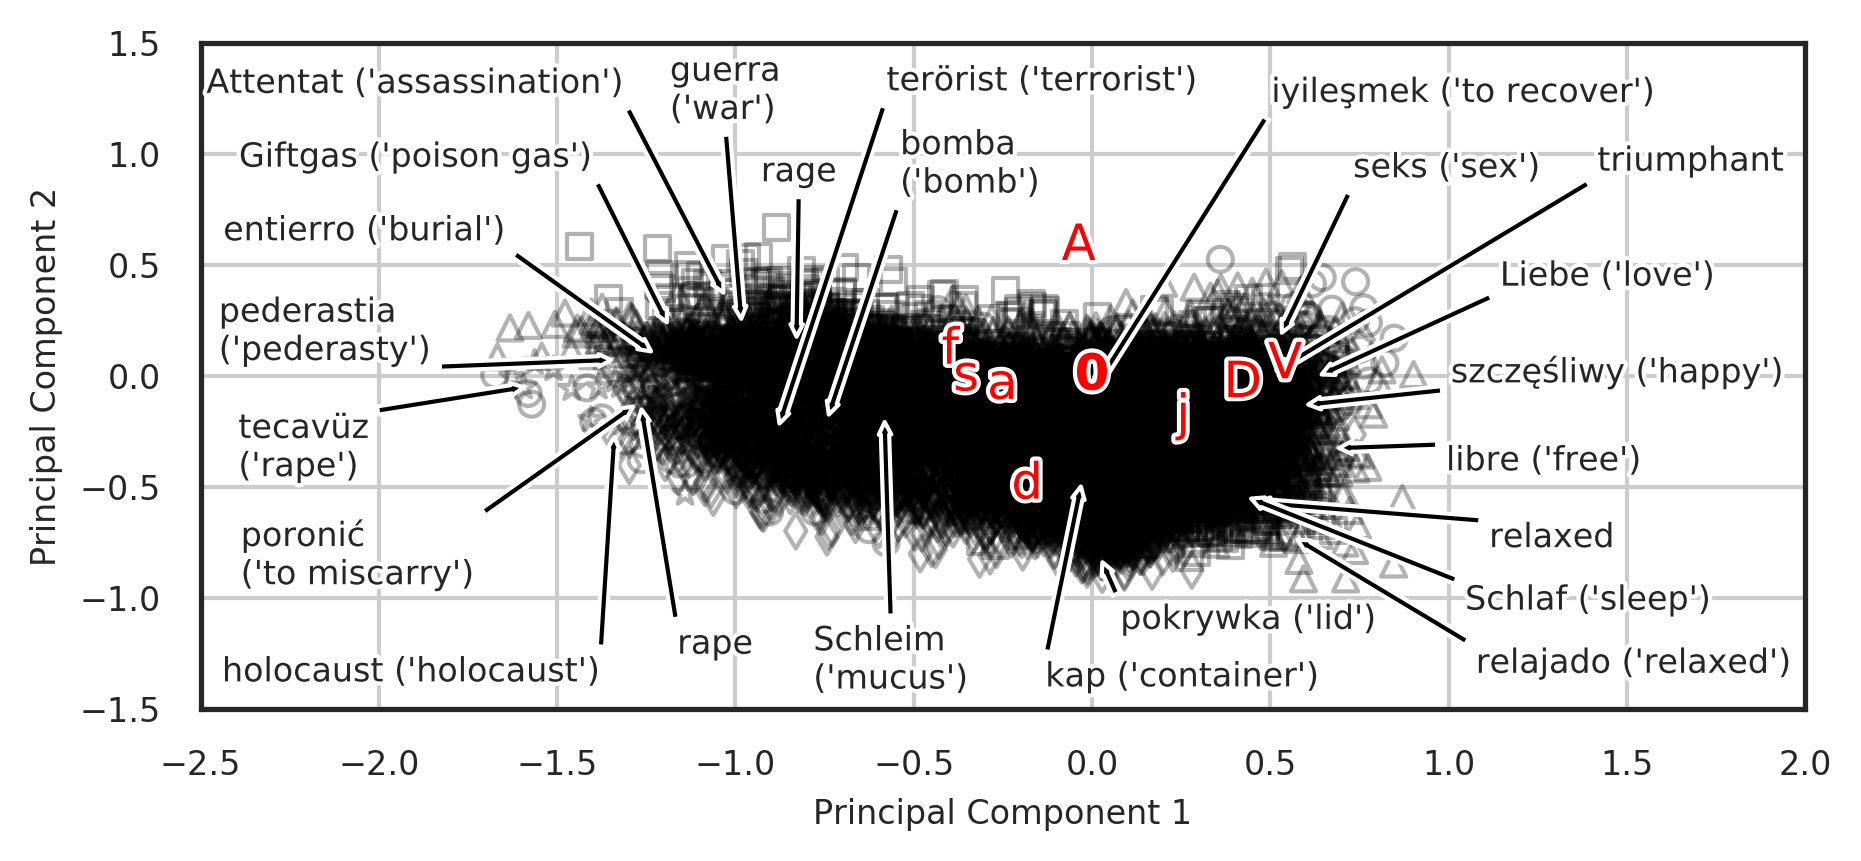

In [15]:
### AGAIN WIS MANY LANGUAGES
fig, ax = plt.subplots(figsize=(2.1*acl_columnwidth_in_inch, 1*acl_columnwidth_in_inch), dpi=300)

ax.set_ylim(-1.5, 1.5)
ax.set_xlim(-2.5, 2.0)

ax.set_xlabel("Principal Component 1", fontsize=8)
ax.set_ylabel("Principal Component 2", fontsize=8)

# changing tick label size
ax.tick_params(axis="both", which="major", labelsize=8)

varNames = {"val": "V",
            "aro": "A",
            "dom": "D",
            "joy": "j",
            "ang": "a",
            "fea": "f",
            "sad": "s",
            "dis": "d"}

for i, var in enumerate(vars2d.index):
    vpos = tuple(vars2d.iloc[i])
    vname = varNames[var]
    ax.text(x=vpos[0], 
            y=vpos[1], 
            s=vname,
            color="red",
            fontsize=12,
            path_effects=[PathEffects.withStroke(linewidth=2,foreground="w")],
            zorder=5,
            verticalalignment="center",
            horizontalalignment="center")
    
# neutral
ax.text(x=0, 
        y=0, 
        s="0",
        color="red",
        weight="bold",
        fontsize=12,
        path_effects=[PathEffects.withStroke(linewidth=2,foreground="w")],
        zorder=5,
        verticalalignment="center",
        horizontalalignment="center")

#ax.scatter(0,0, marker="o", color="red", #path_effects=[PathEffects.withStroke(linewidth=2,foreground="w")]
#          zorder=5, facecolors="none")
    
# All English Words


LANGS  = ["en", "es", "de", "pl", "tr"]

MARKERS = {
    "en": "o",
    "es": "^",
    "de": "s",
    "pl": "d",
    "tr": "*"
}

COORDS = {
    "en": en2d,
    "es": es2d,
    "de": de2d,
    "pl": pl2d,
    "tr": tr2d
}

for l in LANGS:
    coords = COORDS.get(l)
    x,y = coords.iloc[:,0], coords.iloc[:,1]
    ax.scatter(x,y, alpha=.3, marker=MARKERS.get(l), color="black", zorder=1, label=l,
               facecolors="none")


    
    
    
    

# individual words: top/bottom word for V, A, und top word for disgust for  en, es, de, pl, and tr
# (word, translation or None, dx, dy, break)


WORDS = {
    
    "en": [
        ("triumphant", None, +.9,+.9, False),
        ("rape",None, +.1,-1.1, False),
        #rape again,
        ("relaxed", None, +.65, -.2, False),
        ("rage", None, -.1,+.7, False),    
    ],
    
    "es": [
        ("entierro", "burial", -1.2, +.5, False),
        ("libre", "free", +.3,-.1, False),
        ("relajado", "relaxed",+.5,-.6, False),
        ("guerra", "war", -.2 ,.9, True),
        ("pederastia", "pederasty", -1.1, 0, True),
    ],
    
    "de": [
        ("Giftgas", "poison gas", -1.2, +.7, False),
        ("Liebe", "love", +.5, +.4, False),
        ("Schlaf", "sleep", +.6, -.5, False),
        ("Attentat", "assassination", -1.45, +.9, False), # / attack
        ("Schleim", "mucus", -.2, -1.2, True),
        
    ],
    
    "pl": [
        ("poronić", "to miscarry", -1.1,-.8, True),
        ("szczęśliwy", "happy", +.4, +.1, False),
        ("seks", "sex", +.2, +.7, False),
        ("pokrywka", "lid", +.05,-.3, False),
        ("holocaust", "holocaust", -1.1, -1.1, False),
        
    ],
    
    "tr": [
        ("terörist", "terrorist",+.3, +1.5, False),
        ("iyileşmek", "to recover", +.5, +1.3, False),
        ("bomba", "bomb", +.2, +1, True),
        ("kap", "container", -.1, -.9, False),
        ("tecavüz", "rape", -.8, -.4, True),
        
        
    ]
}

#for word in words:
#    w = word[0]
#    print(w)
#    x,y = en2d.loc[w]
#    labelx, labely = x+word[1], y+word[2]
#    ax.annotate(w, xy=(x,y), xytext=(labelx, labely),
#            arrowprops=dict(facecolor='black', 
#                            width=2,
#                            headwidth=4,
#                            headlength=4,
#                           ),
#            path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")]
#               )

for l in LANGS:
    words = WORDS.get(l)
    for word in words:
        w = word[0]
        t = word[1]
        x,y = COORDS.get(l).loc[w]
        labelx, labely = x+word[2], y+word[3]
        
        if t:
            if word[4]:
                w += "\n"
            else:
                w += " "
            #w = f"{l}: {w} ('{t}')"
            w = f"{w}('{t}')"

        
        ax.annotate(w, xy=(x,y), xytext=(labelx, labely), fontsize=8,
            arrowprops=dict(facecolor='black', 
                            width=2,
                            headwidth=3,
                            headlength=3,
                           ),
            path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")]
               )
    
    
    
ax.grid()
plt.tight_layout()
fig.savefig("lexicon-embeddings.jpg")

---